### Load the Data

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

moist = pd.read_csv("sephora_moisturizers.csv")
cleansers = pd.read_csv("sephora_cleansers.csv")

### Get distribution of labels

In [2]:
total = 0
max_label_count = 0
for label in [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]:
    curr_total = np.sum([moist['overall_ratings'] == label])
    max_label_count = max(max_label_count, curr_total)
    total += curr_total
    print(f"Number of rows with label {label}: {curr_total}")

print("Total:", total)
print("BASELINE:", max_label_count / total)
print("\n")

total = 0
max_label_count = 0
for label in [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]:
    curr_total = np.sum([cleansers['overall_ratings'] == label])
    max_label_count = max(max_label_count, curr_total)
    total += curr_total
    print(f"Number of rows with label {label}: {curr_total}")

print("Total:", total)
print("BASELINE:", max_label_count / total)

Number of rows with label 1.0: 1
Number of rows with label 1.5: 0
Number of rows with label 2.0: 2
Number of rows with label 2.5: 3
Number of rows with label 3.0: 13
Number of rows with label 3.5: 76
Number of rows with label 4.0: 277
Number of rows with label 4.5: 307
Number of rows with label 5.0: 28
Total: 707
BASELINE: 0.43422913719943423


Number of rows with label 1.0: 1
Number of rows with label 1.5: 0
Number of rows with label 2.0: 2
Number of rows with label 2.5: 6
Number of rows with label 3.0: 7
Number of rows with label 3.5: 32
Number of rows with label 4.0: 141
Number of rows with label 4.5: 252
Number of rows with label 5.0: 28
Total: 469
BASELINE: 0.5373134328358209


### Map overall_ratings into integer classes

In [3]:
rating_to_int = {1.0: 0,
                1.5: 1,
                2.0: 2,
                2.5: 3,
                3.0: 4,
                3.5: 5,
                4.0: 6,
                4.5: 7,
                5.0: 8}

for dataset in (moist, cleansers):
    new_col = []
    for label in dataset["overall_ratings"]:
        try:
            new_col.append(rating_to_int[label])
        except KeyError:
            print("FOUND NON NUMBER", label)
            new_col.append(len(rating_to_int))
    dataset.loc[:, "overall_ratings"] = pd.Series(new_col)

### Map brands into integer class

In [4]:
brands = set()
for dataset in (moist, cleansers):
    for brand in dataset["brand"]:
        if type(brand) == str:
            brands.add(brand)
        else:
            brands.add("unknown")

brand_to_int = {brand: idx for idx, brand in enumerate(sorted(brands))}

for dataset in (moist, cleansers):
    new_col = []
    for brand in dataset["brand"]:
        if type(brand) == str:
            new_col.append(brand_to_int[brand])
        else:
            new_col.append(brand_to_int["unknown"])
    dataset.loc[:, "brand"] = pd.Series(new_col)

### Map skintypes into integer classes

In [85]:
# All skintypes are some subsets of Normal, Dry, Combination, and Oily

### Transform skincare concerns into integer classes

In [5]:
seen = set()

# after splitting into tokens by commas and "and" we're left
# with only 27 possible concerns. Hardcoded the remaining 
# groups that aren't easily identified through splits

# This reduces the groups to 15, and each is unique

texture = {"uneven texture", "uneven skin textures", "uneven skin texture",
          "dullness/uneven texture", "dullness"}
wrinkles = {"wrinkles", "fine lines", "fine lines/wrinkles"}
firm = {"loss of firmness/elasticity", "loss of firmness", "elasticity"}
tone = {"uneven skin tone", "uneven skintone"}
spots = {"dark spot", "dark spots"}
acne = {"acne", "acne/blemishes", "blemishes"}

for dataset in (moist, cleansers):
    new_col = []
    for concerns in dataset["skincare_concerns"]:
        if type(concerns) == str:
            concerns = concerns.split(", ")
            if "and " == concerns[-1][:4]:
                concerns[-1] = concerns[-1][4:]
            for concern in concerns:
                split_concern = concern.split("and")
                for individual_concern in split_concern:
                    processed = individual_concern.lower().strip()
                    if processed in texture:
                        seen.add("uneven texture")
                    elif processed in wrinkles:
                        seen.add("wrinkles")
                    elif processed in firm:
                        seen.add("loss of firmness")
                    elif processed in tone:
                        seen.add("uneven tone")
                    elif processed in spots:
                        seen.add("dark spots")
                    elif processed in acne:
                        seen.add("acne")
                    else:
                        seen.add(processed)
print(seen)
print(len(seen))

{'wrinkles', 'dryness', 'dark circles', 'uneven tone', 'loss of firmness', 'acne', 'dark spots', 'targets signs of aging', 'puffiness', 'lightweight liquid', 'uneven texture', 'redness', 'oiliness', 'makeup removal', 'pores'}
15


### Make dataset

In [6]:
# brand, skintype, concerns, is_vegan, cruelty_free, award_wins, is_clean, price, review_count, sizing_options, 
# image count, video count

# Omit `concerns` and other stuff for now

# dimensionality will be 11 for now

N = np.shape(moist)[0] + np.shape(cleansers)[0]
total_train_size = int(0.8 * np.shape(moist)[0]) + int(0.8 * np.shape(cleansers)[0])
total_test_size = N - total_train_size

train_data = torch.zeros(total_train_size, 11)
train_labels = torch.zeros(total_train_size)
test_data = torch.zeros(total_test_size, 11)
test_labels = torch.zeros(total_test_size)

is_first = True
for dataset in (moist, cleansers):
    total_samples = np.shape(dataset)[0]
    train_size = int(0.8 * total_samples)
    test_size = total_samples - train_size

    indices = np.arange(total_samples)
    np.random.shuffle(indices)
    curr_train_data = dataset.loc[indices[:train_size], :]
    curr_test_data = dataset.loc[indices[train_size:], :]
    
    if is_first:
        train_labels[:train_size] = torch.tensor([curr_train_data["overall_ratings"].values])
        test_labels[:test_size] = torch.tensor(curr_test_data["overall_ratings"].values)
        
        train_data[:train_size, 0] = torch.tensor(curr_train_data["brand"].values)
        train_data[:train_size, 1] = torch.tensor(curr_train_data["is_vegan"].values, dtype=int)
        train_data[:train_size, 2] = torch.tensor(curr_train_data["is_cruelty_free"].values, dtype=int)
        train_data[:train_size, 3] = torch.tensor(curr_train_data["award_wins"].values, dtype=int)
        train_data[:train_size, 4] = torch.tensor(curr_train_data["is_clean_product"].values, dtype=int)
        train_data[:train_size, 5] = torch.tensor(curr_train_data["price"].values, dtype=int)
        train_data[:train_size, 6] = torch.tensor(curr_train_data["review_count"].values, dtype=int)
        train_data[:train_size, 7] = torch.tensor(curr_train_data["sizing_options_count"].values, dtype=int)
        train_data[:train_size, 8] = torch.tensor(curr_train_data["image_count"].values, dtype=int)
        train_data[:train_size, 9] = torch.tensor(curr_train_data["video_count"].values, dtype=int)
        
        test_data[:test_size, 0] = torch.tensor(curr_test_data["brand"].values)
        test_data[:test_size, 1] = torch.tensor(curr_test_data["is_vegan"].values, dtype=int)
        test_data[:test_size, 2] = torch.tensor(curr_test_data["is_cruelty_free"].values, dtype=int)
        test_data[:test_size, 3] = torch.tensor(curr_test_data["award_wins"].values, dtype=int)
        test_data[:test_size, 4] = torch.tensor(curr_test_data["is_clean_product"].values, dtype=int)
        test_data[:test_size, 5] = torch.tensor(curr_test_data["price"].values, dtype=int)
        test_data[:test_size, 6] = torch.tensor(curr_test_data["review_count"].values, dtype=int)
        test_data[:test_size, 7] = torch.tensor(curr_test_data["sizing_options_count"].values, dtype=int)
        test_data[:test_size, 8] = torch.tensor(curr_test_data["image_count"].values, dtype=int)
        test_data[:test_size, 9] = torch.tensor(curr_test_data["video_count"].values, dtype=int)
        
        for idx in range(train_size):
            curr_skintype = curr_train_data["skin_type"].values[idx]
            
            if type(curr_skintype) == str:
                curr_skintype = curr_skintype.lower()
            else:
                train_data[idx, 10] = 0
                continue
            
            if "normal" in curr_skintype and "dry" in curr_skintype and "oily" in curr_skintype and "combination" in curr_skintype:
                train_data[idx, 10] = 15
            elif "dry" in curr_skintype and "combination" in curr_skintype and "oily" in curr_skintype:
                train_data[idx, 10] = 14
            elif all([elem in curr_skintype for elem in ["normal", "combination", "oily"]]):
                train_data[idx, 10] = 13
            elif all([elem in curr_skintype for elem in ["normal", "dry", "oily"]]):
                train_data[idx, 10] = 12
            elif all([elem in curr_skintype for elem in ["normal", "dry", "combination"]]):
                train_data[idx, 10] = 11
            elif all([elem in curr_skintype for elem in ["combination", "oily"]]):
                train_data[idx, 10] = 10
            elif all([elem in curr_skintype for elem in ["dry", "oily"]]):
                train_data[idx, 10] = 9
            elif all([elem in curr_skintype for elem in ["combination", "dry"]]):
                train_data[idx, 10] = 8
            elif all([elem in curr_skintype for elem in ["normal", "oily"]]):
                train_data[idx, 10] = 7
            elif all([elem in curr_skintype for elem in ["combination", "normal"]]):
                train_data[idx, 10] = 6
            elif all([elem in curr_skintype for elem in ["normal", "dry"]]):
                train_data[idx, 10] = 5
            elif all([elem in curr_skintype for elem in ["oily"]]):
                train_data[idx, 10] = 4
            elif all([elem in curr_skintype for elem in ["combination"]]):
                train_data[idx, 10] = 3
            elif all([elem in curr_skintype for elem in ["dry"]]):
                train_data[idx, 10] = 2
            elif all([elem in curr_skintype for elem in ["normal"]]):
                train_data[idx, 10] = 1   
                
        for idx in range(test_size):
            curr_skintype = curr_test_data["skin_type"].values[-test_size + idx]
            if type(curr_skintype) == str:
                curr_skintype = curr_skintype.lower()
            else:
                test_data[-test_size + idx, 10] = 0
                continue
        
            if "normal" in curr_skintype and "dry" in curr_skintype and "oily" in curr_skintype and "combination" in curr_skintype:
                test_data[-test_size + idx, 10] = 15
            elif "dry" in curr_skintype and "combination" in curr_skintype and "oily" in curr_skintype:
                test_data[-test_size + idx, 10] = 14
            elif all([elem in curr_skintype for elem in ["normal", "combination", "oily"]]):
                test_data[-test_size + idx, 10] = 13
            elif all([elem in curr_skintype for elem in ["normal", "dry", "oily"]]):
                test_data[-test_size + idx, 10] = 12
            elif all([elem in curr_skintype for elem in ["normal", "dry", "combination"]]):
                test_data[-test_size + idx, 10] = 11
            elif all([elem in curr_skintype for elem in ["combination", "oily"]]):
                test_data[-test_size + idx, 10] = 10
            elif all([elem in curr_skintype for elem in ["dry", "oily"]]):
                test_data[-test_size + idx, 10] = 9
            elif all([elem in curr_skintype for elem in ["combination", "dry"]]):
                test_data[-test_size + idx, 10] = 8
            elif all([elem in curr_skintype for elem in ["normal", "oily"]]):
                test_data[-test_size + idx, 10] = 7
            elif all([elem in curr_skintype for elem in ["combination", "normal"]]):
                test_data[-test_size + idx, 10] = 6
            elif all([elem in curr_skintype for elem in ["normal", "dry"]]):
                test_data[-test_size + idx, 10] = 5
            elif all([elem in curr_skintype for elem in ["oily"]]):
                test_data[-test_size + idx, 10] = 4
            elif all([elem in curr_skintype for elem in ["combination"]]):
                test_data[-test_size + idx, 10] = 3
            elif all([elem in curr_skintype for elem in ["dry"]]):
                test_data[-test_size + idx, 10] = 2
            elif all([elem in curr_skintype for elem in ["normal"]]):
                test_data[-test_size + idx, 10] = 1
        is_first = False
    else:
        train_labels[-train_size:] = torch.tensor(curr_train_data["overall_ratings"].values)
        test_labels[-test_size:] = torch.tensor(curr_test_data["overall_ratings"].values)
        
        train_data[-train_size:, 0] = torch.tensor(curr_train_data["brand"].values)
        train_data[-train_size:, 1] = torch.tensor(curr_train_data["is_vegan"].values, dtype=int)
        train_data[-train_size:, 2] = torch.tensor(curr_train_data["is_cruelty_free"].values, dtype=int)
        train_data[-train_size:, 3] = torch.tensor(curr_train_data["award_wins"].values, dtype=int)
        train_data[-train_size:, 4] = torch.tensor(curr_train_data["is_clean_product"].values, dtype=int)
        train_data[-train_size:, 5] = torch.tensor(curr_train_data["price"].values, dtype=int)
        train_data[-train_size:, 6] = torch.tensor(curr_train_data["review_count"].values, dtype=int)
        train_data[-train_size:, 7] = torch.tensor(curr_train_data["sizing_options_count"].values, dtype=int)
        train_data[-train_size:, 8] = torch.tensor(curr_train_data["image_count"].values, dtype=int)
        train_data[-train_size:, 9] = torch.tensor(curr_train_data["video_count"].values, dtype=int)

        test_data[-test_size:, 0] = torch.tensor(curr_test_data["brand"].values)
        test_data[-test_size:, 1] = torch.tensor(curr_test_data["is_vegan"].values, dtype=int)
        test_data[-test_size:, 2] = torch.tensor(curr_test_data["is_cruelty_free"].values, dtype=int)
        test_data[-test_size:, 3] = torch.tensor(curr_test_data["award_wins"].values, dtype=int)
        test_data[-test_size:, 4] = torch.tensor(curr_test_data["is_clean_product"].values, dtype=int)
        test_data[-test_size:, 5] = torch.tensor(curr_test_data["price"].values, dtype=int)
        test_data[-test_size:, 6] = torch.tensor(curr_test_data["review_count"].values, dtype=int)
        test_data[-test_size:, 7] = torch.tensor(curr_test_data["sizing_options_count"].values, dtype=int)
        test_data[-test_size:, 8] = torch.tensor(curr_test_data["image_count"].values, dtype=int)
        test_data[-test_size:, 9] = torch.tensor(curr_test_data["video_count"].values, dtype=int)

        for idx in range(train_size):
            curr_skintype = curr_train_data["skin_type"].values[idx]

            if type(curr_skintype) == str:
                curr_skintype = curr_skintype.lower()
            else:
                train_data[-(train_size + idx), 10] = 0
                continue

            if "normal" in curr_skintype and "dry" in curr_skintype and "oily" in curr_skintype and "combination" in curr_skintype:
                train_data[-(train_size + idx), 10] = 15
            elif "dry" in curr_skintype and "combination" in curr_skintype and "oily" in curr_skintype:
                train_data[-(train_size + idx), 10] = 14
            elif all([elem in curr_skintype for elem in ["normal", "combination", "oily"]]):
                train_data[-(train_size + idx), 10] = 13
            elif all([elem in curr_skintype for elem in ["normal", "dry", "oily"]]):
                train_data[-(train_size + idx), 10] = 12
            elif all([elem in curr_skintype for elem in ["normal", "dry", "combination"]]):
                train_data[-(train_size + idx), 10] = 11
            elif all([elem in curr_skintype for elem in ["combination", "oily"]]):
                train_data[-(train_size + idx), 10] = 10
            elif all([elem in curr_skintype for elem in ["dry", "oily"]]):
                train_data[-(train_size + idx), 10] = 9
            elif all([elem in curr_skintype for elem in ["combination", "dry"]]):
                train_data[-(train_size + idx), 10] = 8
            elif all([elem in curr_skintype for elem in ["normal", "oily"]]):
                train_data[-(train_size + idx), 10] = 7
            elif all([elem in curr_skintype for elem in ["combination", "normal"]]):
                train_data[-(train_size + idx), 10] = 6
            elif all([elem in curr_skintype for elem in ["normal", "dry"]]):
                train_data[-(train_size + idx), 10] = 5
            elif all([elem in curr_skintype for elem in ["oily"]]):
                train_data[-(train_size + idx), 10] = 4
            elif all([elem in curr_skintype for elem in ["combination"]]):
                train_data[-(train_size + idx), 10] = 3
            elif all([elem in curr_skintype for elem in ["dry"]]):
                train_data[-(train_size + idx), 10] = 2
            elif all([elem in curr_skintype for elem in ["normal"]]):
                train_data[-(train_size + idx), 10] = 1
    
        for idx in range(test_size):
            curr_skintype = curr_test_data["skin_type"].values[-test_size + idx]

            if type(curr_skintype) == str:
                curr_skintype = curr_skintype.lower()
            else:
                test_data[-test_size + idx, 10] = 0
                continue

            if "normal" in curr_skintype and "dry" in curr_skintype and "oily" in curr_skintype and "combination" in curr_skintype:
                test_data[-test_size + idx, 10] = 15
            elif "dry" in curr_skintype and "combination" in curr_skintype and "oily" in curr_skintype:
                test_data[-test_size + idx, 10] = 14
            elif all([elem in curr_skintype for elem in ["normal", "combination", "oily"]]):
                test_data[-test_size + idx, 10] = 13
            elif all([elem in curr_skintype for elem in ["normal", "dry", "oily"]]):
                test_data[-test_size + idx, 10] = 12
            elif all([elem in curr_skintype for elem in ["normal", "dry", "combination"]]):
                test_data[-test_size + idx, 10] = 11
            elif all([elem in curr_skintype for elem in ["combination", "oily"]]):
                test_data[-test_size + idx, 10] = 10
            elif all([elem in curr_skintype for elem in ["dry", "oily"]]):
                test_data[-test_size + idx, 10] = 9
            elif all([elem in curr_skintype for elem in ["combination", "dry"]]):
                test_data[-test_size + idx, 10] = 8
            elif all([elem in curr_skintype for elem in ["normal", "oily"]]):
                test_data[-test_size + idx, 10] = 7
            elif all([elem in curr_skintype for elem in ["combination", "normal"]]):
                test_data[-test_size + idx, 10] = 6
            elif all([elem in curr_skintype for elem in ["normal", "dry"]]):
                test_data[-test_size + idx, 10] = 5
            elif all([elem in curr_skintype for elem in ["oily"]]):
                test_data[-test_size + idx, 10] = 4
            elif all([elem in curr_skintype for elem in ["combination"]]):
                test_data[-test_size + idx, 10] = 3
            elif all([elem in curr_skintype for elem in ["dry"]]):
                test_data[-test_size + idx, 10] = 2
            elif all([elem in curr_skintype for elem in ["normal"]]):
                test_data[-test_size + idx, 10] = 1

### Define neural network

In [42]:
input_size = 11
output_size = len(rating_to_int)
embed_dim = 10

class Predictor(nn.Module):
    def __init__(self, hidden_size):
        super(Predictor, self).__init__()
        self.layer0 = nn.Linear(input_size, hidden_size)
        self.activation = nn.ReLU()
        self.layer1 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.layer0(x)
        x = self.activation(x)
        return self.layer1(x)

### Train neural network

0 1
1 0
2 1
3 3
4 3
5 23
6 69
7 126
8 10
9 0
best combo 0.1 16 0.5338983050847458


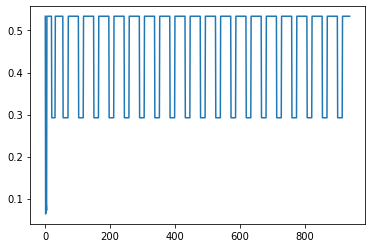

best combo 0.1 256 0.5423728813559322


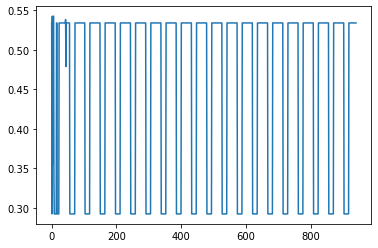

best combo 0.01 64 0.5466101694915254


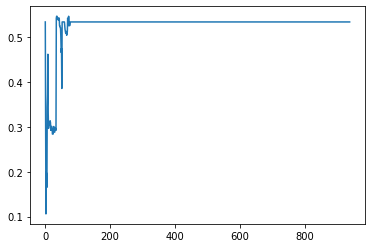

best combo 0.001 32 0.5508474576271186


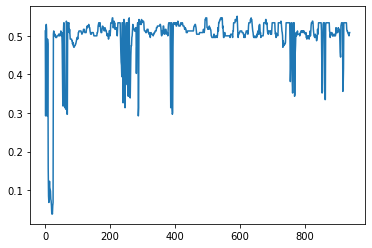

In [49]:
def train(model, train_data, train_labels, val_data, val_labels, epochs, optimizer, loss_fn, print_freq, batch_size):
    losses = []
    accuracies = []
    N = val_data.shape[0]
    best_acc = 0
    
    for epoch in range(epochs):
        idx = 0
        for iteration in range(train_data.shape[0] // batch_size):
            batch = train_data[iteration * batch_size : (iteration + 1) * batch_size, :]
            targets = train_labels[iteration * batch_size : (iteration + 1) * batch_size]
            optimizer.zero_grad()
            out = model(batch)
            loss = loss_fn(out, targets)
            loss.backward()
            optimizer.step()

            if idx % print_freq == 0:
                losses.append(loss.item())
                with torch.no_grad():
                    val_out = model(val_data)
                    preds = torch.topk(val_out, 1).indices.squeeze()
                    acc = torch.sum(preds == val_labels.squeeze()).item() / N
                    accuracies.append(acc)
                    
                    if acc > best_acc:
                        best_acc = acc
            idx += 1
    return losses, accuracies, best_acc

train_labels = train_labels.long()
test_labels = test_labels.long()

for i in range(10):
    print(i, torch.sum(test_labels == i).item())

best_acc = 0
best_model = None
for lr in [0.1, 0.01, 0.001, 0.0001]:
    for hidden_size in [16, 32, 64, 128, 256]:
        model = Predictor(hidden_size)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
        l, a, acc = train(model, train_data, train_labels, test_data, test_labels, 20, optimizer, \
                     nn.CrossEntropyLoss(), 1, 20)
        if acc > best_acc:
            print("best combo", lr, hidden_size, acc)
            best_acc = acc
            best_model = model
            plt.plot(a)
            plt.show()